# Building Micrograd

Tiny autograd engine - implements backpropogation (reverse-mode-autodiff) over a dynamically built DAG (engine.py)

and a small neural network library (nn.py) on top of micrograd engine with a Pytorch-like API

Both are tiny

The DAG only operates over scalar values (rather than vectors) - so we chop up each nueron into all of its individual tiny adds adn multiplies
- Simplifies things to help you grok backpropogation 

If you want to train bigger networks you need to use tensors - this helps computation but none of the math actually changes
 - Tensors are just "arrays" of scalars - large arrays allow us to take advangage of parrallism of computer - but math is the same

So start with scalars to grok backpropogation

Everything else is just efficiency (that being said there is a lot to efficiency hahaahhaha)

Backpropogation - recursively applies the chain rule so can find the derivative of g with respect to all of the different nodes

derivate tells us how the nodes affect the output - obviously this is useful to train the network

Backpropogation is much more general than neural networks - it jsut happens that it is very useful to train neural nets 

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# see micrograd 1 for walkthrough of all the steps


In [2]:
class Value:

    def __init__(self,data, _children = (), _op = (), label = (), parent_grad = ()):
        self.data = data
        self._prev = set(_children)
            # _children will be a tuple but will be held as a set in the class _prev - just done for efficiency
        self._op = _op
        self.label = label

        #derivative
        self.grad = 0.0 # initialized at 0 - assume that value does not effect output at the start
        
        #backpop funciton
        self._backward = lambda: None

    def __repr__(self):
        #python interally uses this repr function to return this string when the object is called on its own
        return f"Value(data={self.data})"
    
    #need to define addition
    def __add__(self,other):
        #check if other is a value object and make it one if not
        other = other if isinstance(other, Value) else Value(other)

        #use special underscore emthods to define operators in pytho
        # e.g. if we od a + b, python will interally do a.__add__(b)
        out = Value(self.data + other.data, _children = (self,other), _op = "+" )#this operator works as it is operating on self.data which is jsut a python number rather than our value class, second part is feeding in the _children expression to the new value obejct
        
        # definint g the function that propgates the gradient
        def _backward():
            # we want to propogate outs.grad and change self.grad and other.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * self.grad

            # #recursive call ?not implemented
            # self._backward()
            # other._backward()
        out._backward = _backward

        return out
    
    #same for multiplication
    def __mul__(self, other):
        #check if other is a value object and make it one if not
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self,other), "*") #this operator works as it is operating on self.data which is jsut a python number rather than our value class
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

            # #recursive calls - think abotu variable scope it makes ense
            # self._backward()
            # other._backward()
        out._backward = _backward
        
        return out

    def __neg__(self): #-self
        return self * -1

    def __sub__(self,other): #self - other
        return self + (-other) #saves us rewriting addition #wowowowo
        
    def __rmul__(self,other): #other * self reverse multiplication
        #this is a fallback - if __mul__ doesnt work - so python will then check if the second term has a rmul
        # this seems super ineficient but i guess that is the poubt
        return self * other 
    
    def __truediv__(self,other):
        #division is a special case of exponentiation x**k a/b = a * b**-1
        return self * other**-1


    def exp(self):
        # app exponentiation
        x = self.data
        out = Value(math.exp(x), (self,), "exp") #only 1 child

        def _backward():
            #same pointer trickery as before
            self.grad += out.grad * out.data

        out._backward = _backward

        return out

    def __pow__(self,k):
        #other must be a int/float for now
        #otherwise math wont work for  aspecific case ??? cant backprop to the k value - makes sense
        assert isinstance(k, (int,float))

        out = Value(self.data**k, (self,), "**{}".format(k))

        def _backward():
            #calculus baby x**k = k*x**(k-1)
            # remember out.grad is the reverse chain rule component
            self.grad += out.grad * k*((self.data)**(k-1))

        out._backward = _backward

        return out



    #defined activation function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh") #only 1 child

        def _backward():
            
            self.grad += out.grad * (1 - t**2)
            
            #having a bit of trouble figuring out the variable scope here
            #this function is not kept as a string but insted references the object pointers used when initializing it
            # when we "set" the function below
            # the function references self from the current variable scope - inside the tanh funciton where self refers not to the out Value but to the value which will create out

            # some simple debugging
            # print whatever self is when reference - when we call out._backwards we will see it prints the current self rather than out itself
            # This sounds schizophrenic but makes sense if you think about it enough
            # when you 

            # I have read the docs and returned wiser
            # when you define the function you bind the function tot he local namespace and the function object 
            # containes reference tot eh current global namespace as the flobal namespace tot be used when the 
            # function is called
            # so when we define the function ehre it remembers this tanh() function as the namespace and within
            # this space self refers to the object that is to create out
            # MAEKS SESNE
            # https://docs.python.org/3/reference/compound_stmts.html#function
            # print(self)
            
            # recusrive call not implemented
            # self._backward()


        out._backward = _backward
        
        return out
    

    #also want to make the connective tissue of the expression - keep expression graphs simple pointers
    #_children argument added

    #also need to know what operation created each value
    #_op


    #also want a way to visualize these expressions
    #see cell below

    # add labels _label

    #add another variable which keeps track of the derivative of L with respect to that value

    # #my attempt at writing it - to compare with the GOAT
    # def backprop(self, _parent_grad = (), _op = (), _sibling = ()):
        
    #     # Dont use unnecesary parent grad variable
    #     # can convey all the information reqiured for recursive function in the function call
    #     # previuosly used self.parent_grad function - uneccesary

    #     print(self.label, _parent_grad, _op, _sibling)
        
    #     if _parent_grad == ():
    #         #base case
    #         self.grad = 1 
    #         #derivative with respect to itself will be 1 always

    #     else:
    #         # apply chain rule using the parent grad
    #         if _op == "*":
    #             self.grad = _parent_grad * _sibling.data # parent = c1 * c2 ; dparent/dc1 = c2
    #         elif _op == "+":
    #             self.grad = _parent_grad * 1 # parent = c1 + c2 ; dparent/dc1 = 1 + 0 = 1

    #     if self._prev != set():
    #         #each nodes is assumed to have 2 children
    #         child1 , child2 = self._prev
            
    #         #unnecessarily pass sibling node even if addition
    #         child1.backprop(_parent_grad = self.grad, _op = self._op, _sibling = child2)
    #         child2.backprop(_parent_grad = self.grad, _op = self._op, _sibling = child1)

    # Kaprpathy backpopogates through each operation
    # ?just changes the childern directly and hten backprops through - makes way more sense as can handle larger sums :)
    # ?still need to check base case 
    # Karpathy getting fucking clever and using almbda functions
    # written into the code of building a network he specifies how to backprop over it 
    # seems weird but we will trust the GOAT
    
    def backward(self):
        #actaul backprop function - builds topolical tree and applies _backward attribute on it
    
        # building a topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)       
                topo.append(v) #only adds itself after all the children are processed
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()
        
            

 
    




In [3]:
# writing up a little function that installs 

from graphviz import Digraph

def trace(root):
    # root = starting Value object to build tree from

    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child) #recursive call to repeat addition on each child
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = "svg", graph_attr={"rankdir":"LR"}) #LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any vlaue in hte graph, create a rectuangular ("record") node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %s}" % (n.label, n.data,n.grad), shape = "record")
        if n._op: #if n is the result of an opertaion
            #if this value is a result of some operation, creat an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid+n._op,uid)
    
    for n1, n2 in edges:
            # connect n1 to the op node of n2
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

#draw_dot(L)


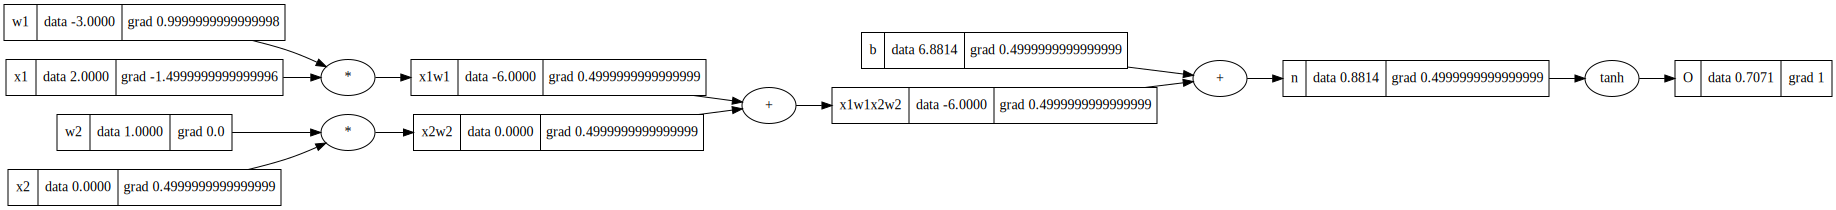

In [4]:
#inputts x1,x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias 
b = Value(6.881373587019543, label = "b")

#neuron x1w1 + x2w2 + b
# need to do intermediate steps
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"

O = n.tanh() ; O.label = "O"
O.backward()

draw_dot(O)



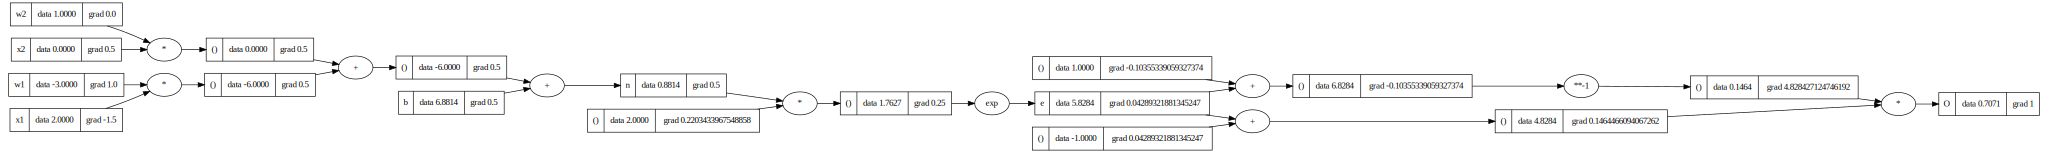

In [5]:
#inputts x1,x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias 
b = Value(6.8813735870195432, label = "b")

#neuron x1w1 + x2w2 + b
# need to do intermediate steps
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
#n = x1w1x2w2 + b; n .label = "n"
n = x1*w1 + x2*w2 + b; n.label = "n"

#-----
e = (2*n).exp(); e.label = "e"
O = (e - 1) / (e + 1); O.label = "O"
#------
O.backward()

draw_dot(O)

# implementing tanh as a function of e^x as a sanity check and to learn about exponentials

# Now doing it all in pytorch

In [6]:
torch.Tensor([[1,2,3],[4,5,6]])

NameError: name 'torch' is not defined

In [ ]:
import torch

#in pytorch everything is based on tensore n dimensionall arrays of tensors
# python by default uses double precision floating point numbers float64
#wheras in torch the tensor default type if float 32 -?single position float

# need to explicitly state that all these nodes require gradients
# by defautl these are set to Flase as we generally do not want gradients for the leaf nodes - the inputs - for efficiency
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

#.item() strips out the tensor
print(o.data.item())
o.backward()

print("----")
print("x2",x2.grad.item())
print("w2",w2.grad.item())
print("x1",x1.grad.item())
print("w2",w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 1.0000002567688737


# **building out a neural net following the pytorch API**


In [ ]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] 